In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(43, 24)

In [6]:
df_states.shape

(2000, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-04-06,56,363800,1561229.0,17292.0,32210.0,43198.0,6943.0,814.0,2961.0,...,10720,43198.0,1942321,1925029,1925029,1166.0,2975.0,120496.0,28731.0,149227.0
3,2020-04-07,56,394210,1678891.0,16557.0,39677.0,45500.0,9875.0,889.0,4076.0,...,12646,45500.0,2089658,2073101,2073101,1926.0,2302.0,117662.0,30410.0,148072.0
2,2020-04-08,56,424391,1788294.0,17228.0,41095.0,47154.0,9927.0,1013.0,4131.0,...,14547,47154.0,2229913,2212685,2212685,1901.0,1654.0,109403.0,30181.0,139584.0
1,2020-04-09,56,458474,1916737.0,17631.0,46665.0,48344.0,12244.0,924.0,5794.0,...,16424,48344.0,2392842,2375211,2375211,1877.0,1190.0,128443.0,34083.0,162526.0
0,2020-04-10,56,491156,2028486.0,17444.0,48344.0,50559.0,12688.0,1174.0,5937.0,...,18356,50559.0,2537086,2519642,2519642,1932.0,2215.0,111749.0,32682.0,144431.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-10,NE,635.0,8719.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9354,9354,9354,31,1.0,0.0,603.0,68.0,671.0
31,2020-04-10,ND,278.0,9330.0,NaN,13.0,36.0,NaN,NaN,NaN,...,36.0,9608,9608,9608,38,1.0,2.0,609.0,9.0,618.0
30,2020-04-10,NC,3908.0,53737.0,NaN,423.0,NaN,NaN,NaN,NaN,...,NaN,57645,57645,57645,37,9.0,0.0,9579.0,257.0,9836.0
28,2020-04-10,MS,2469.0,18632.0,NaN,NaN,482.0,NaN,NaN,NaN,...,482.0,21101,21101,21101,28,6.0,41.0,0.0,209.0,209.0
0,2020-04-10,AK,246.0,7186.0,NaN,NaN,28.0,NaN,NaN,NaN,...,28.0,7432,7432,7432,2,0.0,1.0,198.0,11.0,209.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per 100,000
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e5)

# Calculate hospitalized per 100,000
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e5)

# Calculate deaths per 100,000
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e5)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per 100,000 people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e5)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
1891,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1892,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
1893,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1894,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1895,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,1896.000000,1785.000000,459.000000,284.000000,541.000000,98.000000,72.000000,97.000000,20.000000,269.000000,...,1844.000000,1896.000000,1.896000e+03,1870.000000,1896.000000,541.000000,1228.000000,1780.000000,1785.000000,922.000000
mean,2430.772152,11517.075070,1711.854031,1420.475352,947.881701,916.469388,117.847222,293.556701,65.750000,640.583643,...,1365.156182,29.683544,6.483026e+06,429.402757,28.549251,8.258698,1.151085,0.125405,241.474896,87.638054
std,10675.600681,23356.959154,8802.960096,3289.329058,3968.798287,1290.255567,129.020979,415.338365,37.105646,2312.117004,...,3312.067217,16.387590,7.320164e+06,1593.946853,71.042065,20.172943,2.982974,0.132772,322.015083,362.035076
min,0.000000,0.000000,0.000000,11.000000,0.000000,9.000000,6.000000,4.000000,2.000000,2.000000,...,-585.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,170.000000,5.000000,56.000000,33.000000,55.500000,16.750000,22.000000,39.000000,35.000000,...,24.000000,16.750000,1.805832e+06,54.955978,0.436407,1.926924,0.066816,0.049684,6.195640,4.142857
50%,184.500000,2779.000000,29.000000,165.000000,130.000000,190.500000,83.500000,39.000000,41.000000,76.000000,...,287.000000,30.000000,4.468402e+06,109.860468,5.634727,3.915501,0.325172,0.089079,90.119010,14.142857
75%,1077.000000,12590.000000,152.500000,1266.000000,410.000000,1166.000000,163.750000,507.000000,108.000000,208.000000,...,1328.250000,44.000000,7.535591e+06,229.511156,28.147890,7.268815,0.949842,0.152743,383.824900,49.535714
max,170512.000000,247373.000000,64400.000000,18569.000000,33159.000000,4925.000000,548.000000,1663.000000,108.000000,14590.000000,...,78400.000000,72.000000,3.955704e+07,11490.119540,872.531862,169.678873,40.138758,0.891705,2138.371358,5592.857143


## California

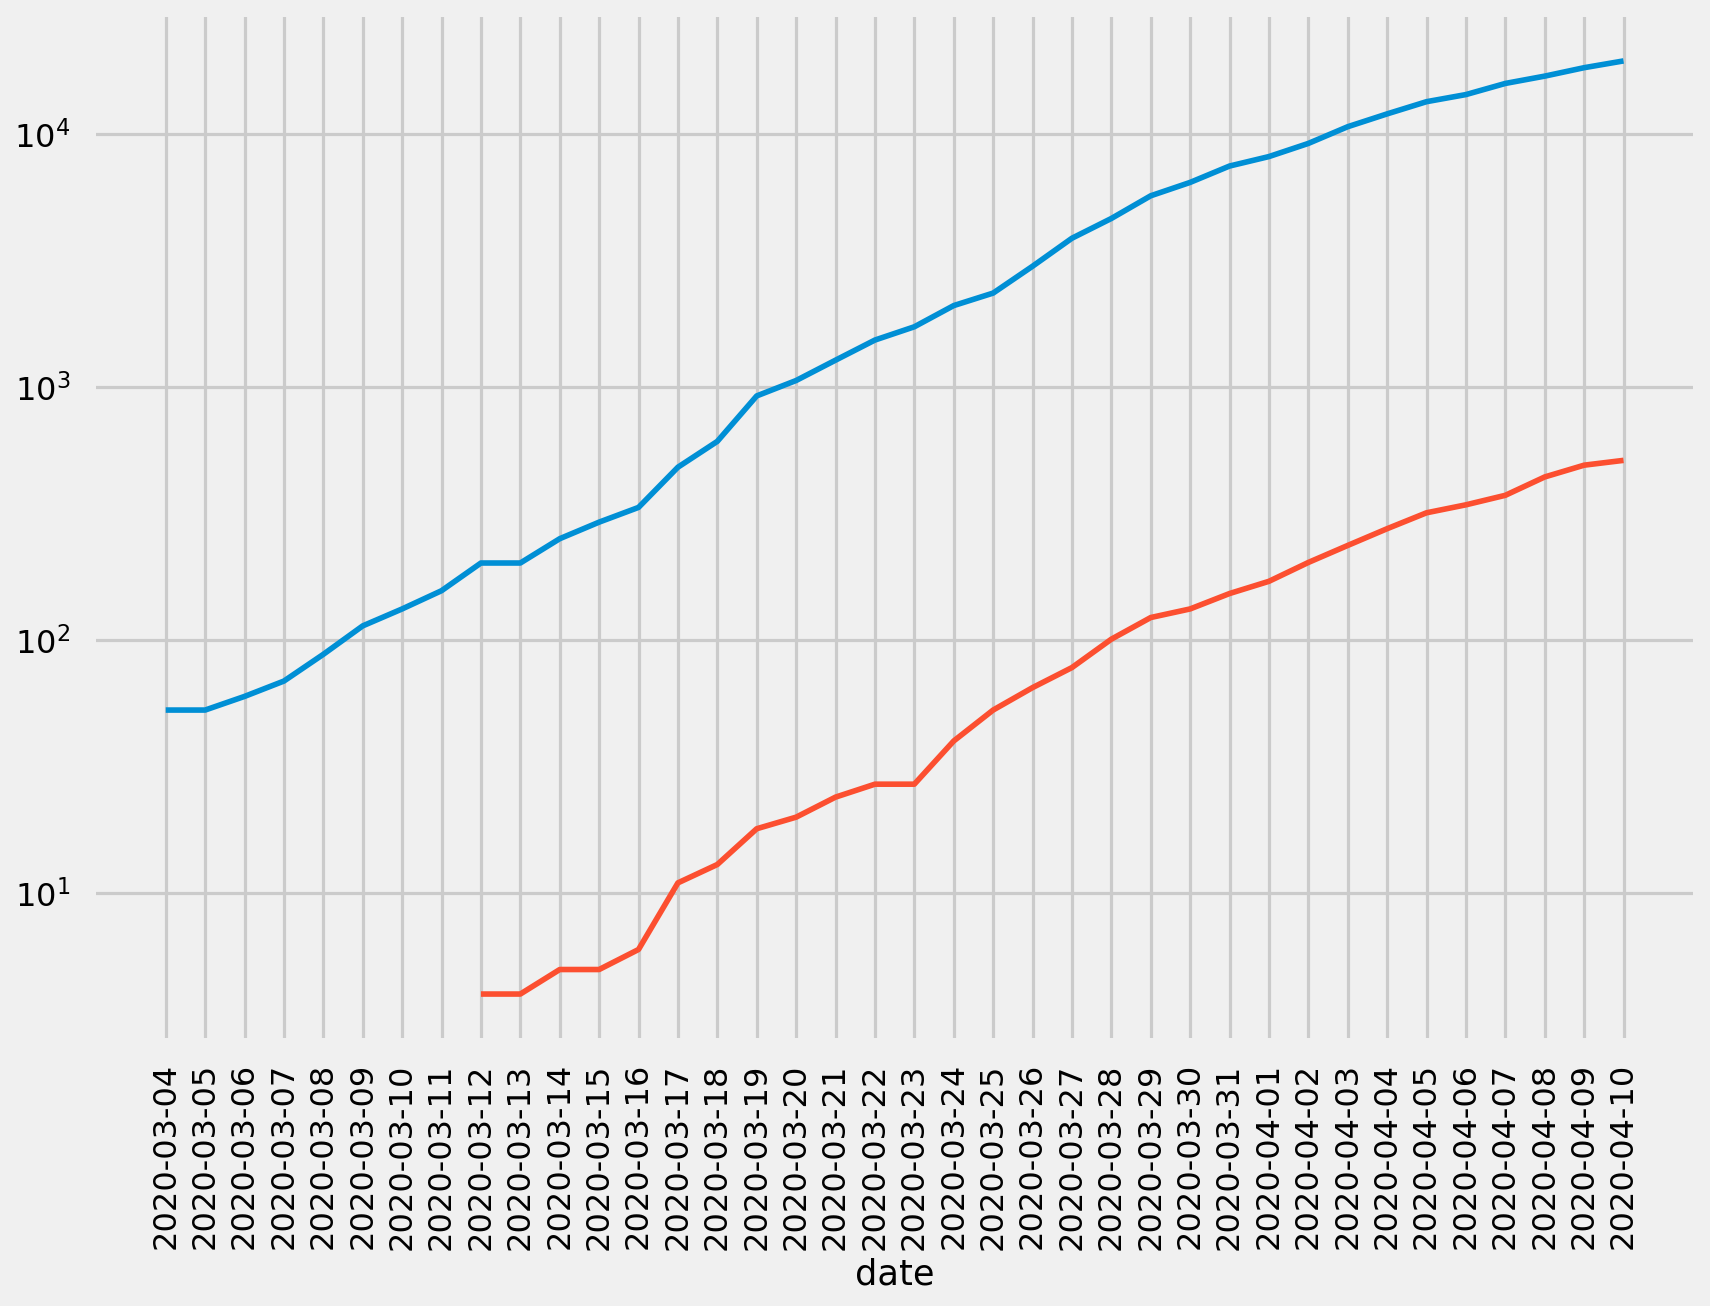

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

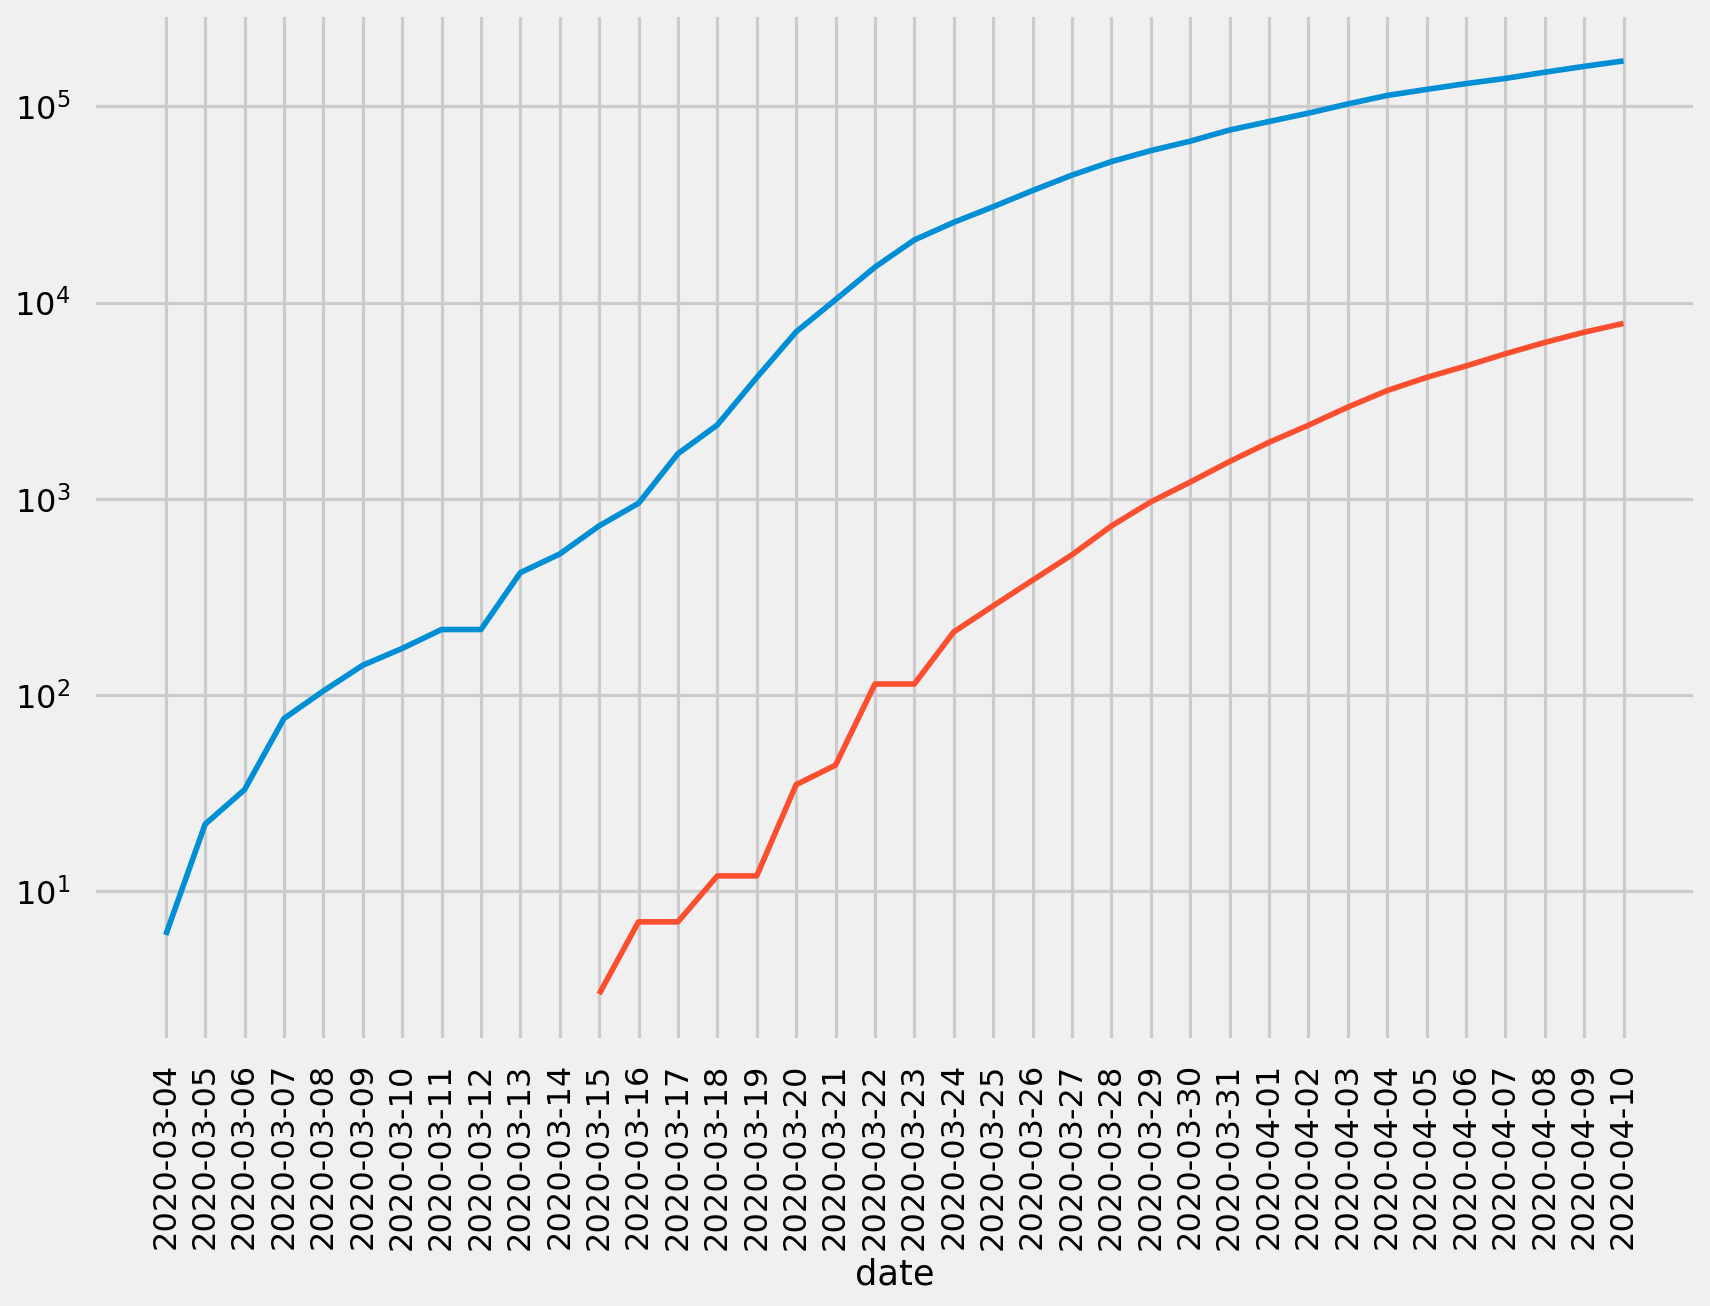

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'LA', 'MA', 'IL', 'CA', 'WA', 'GA', 'PA']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1237,NY,7844.0
1127,NJ,1932.0
801,MI,1281.0
656,LA,755.0
691,MA,599.0
510,IL,596.0
145,CA,514.0
1744,WA,446.0
366,GA,416.0
1385,PA,416.0


In [18]:
# Deaths per 100,000 people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1237,NY,40.138758
1127,NJ,21.687104
656,LA,16.201793
801,MI,12.815235
220,CT,10.636318
691,MA,8.678457
1744,WA,5.918580
255,DC,5.409599
510,IL,4.677782
1447,RI,4.634380


# Deaths

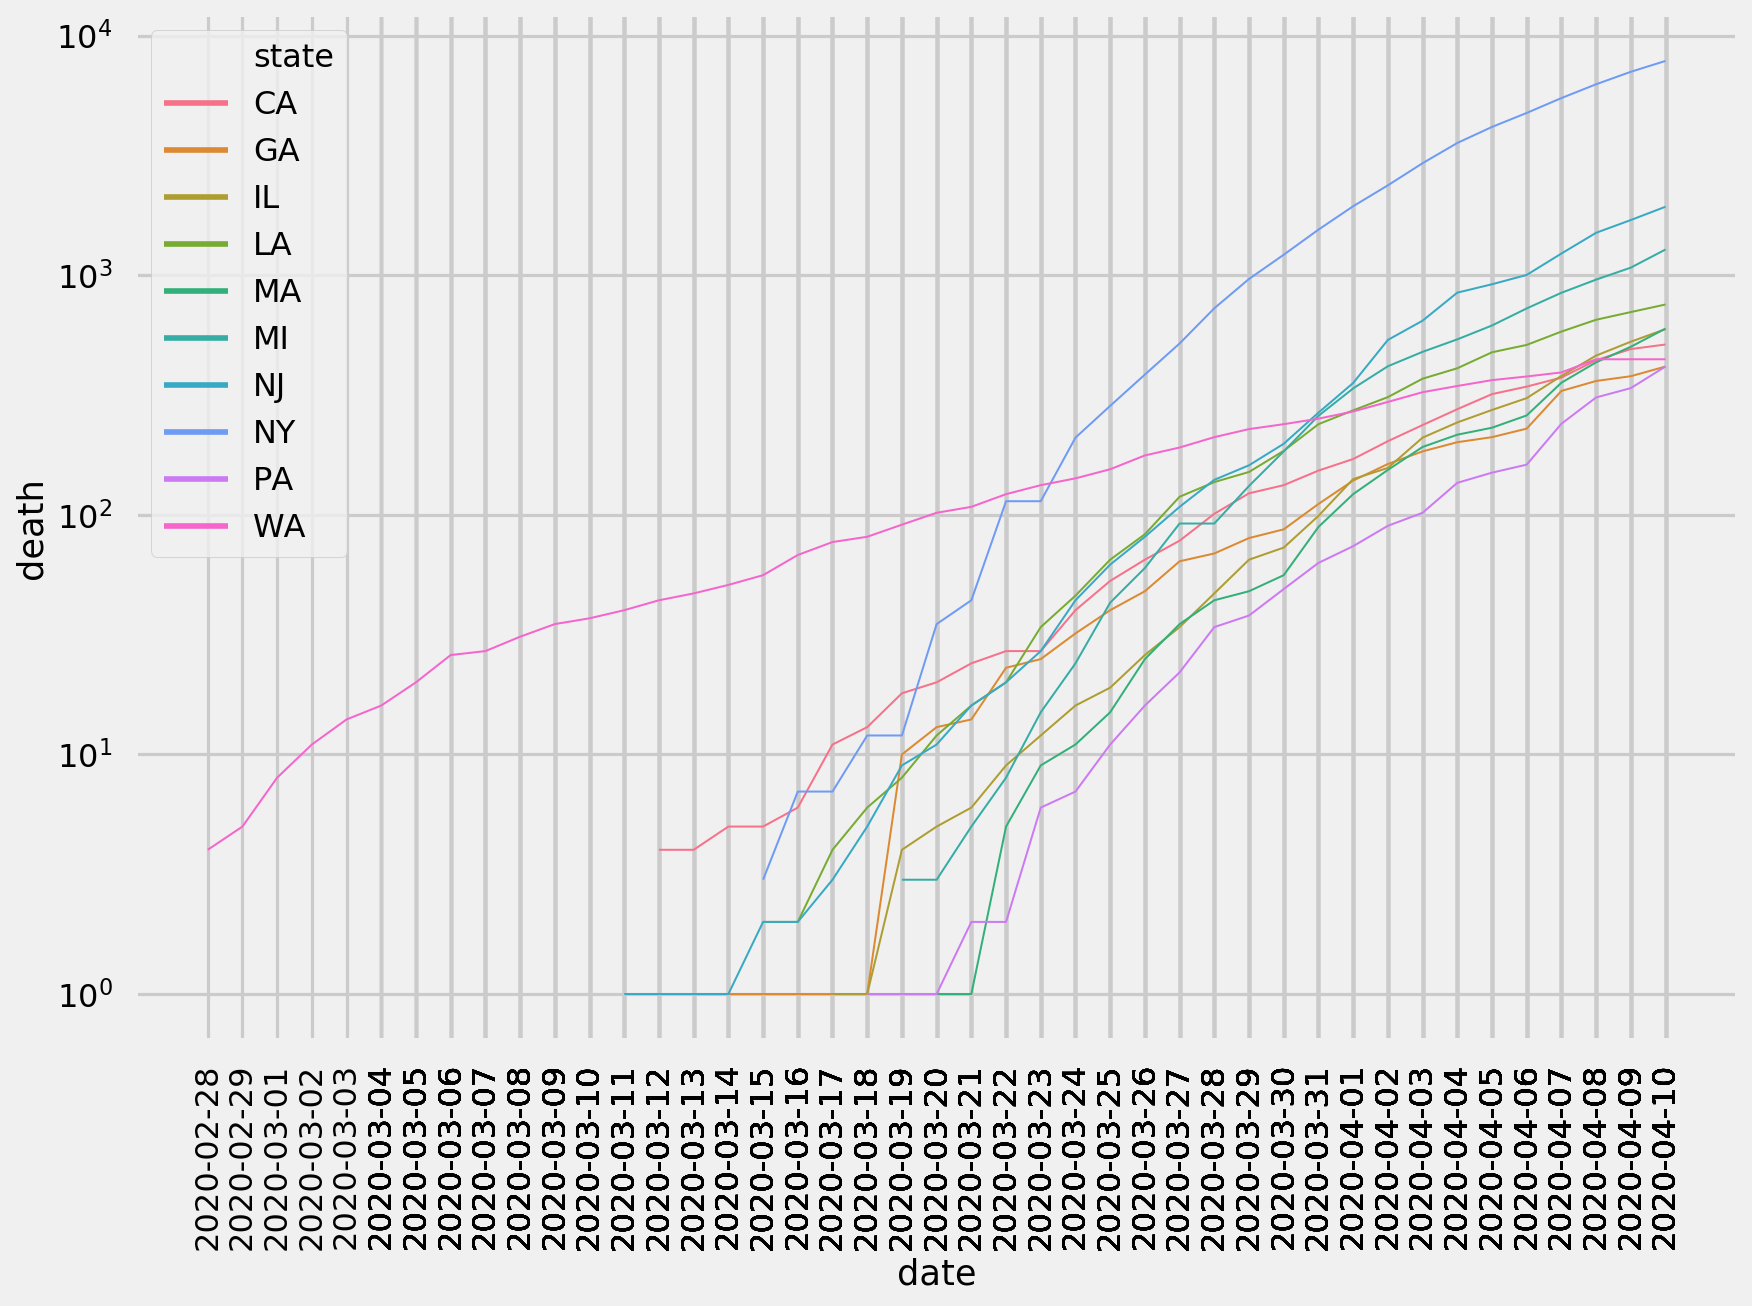

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

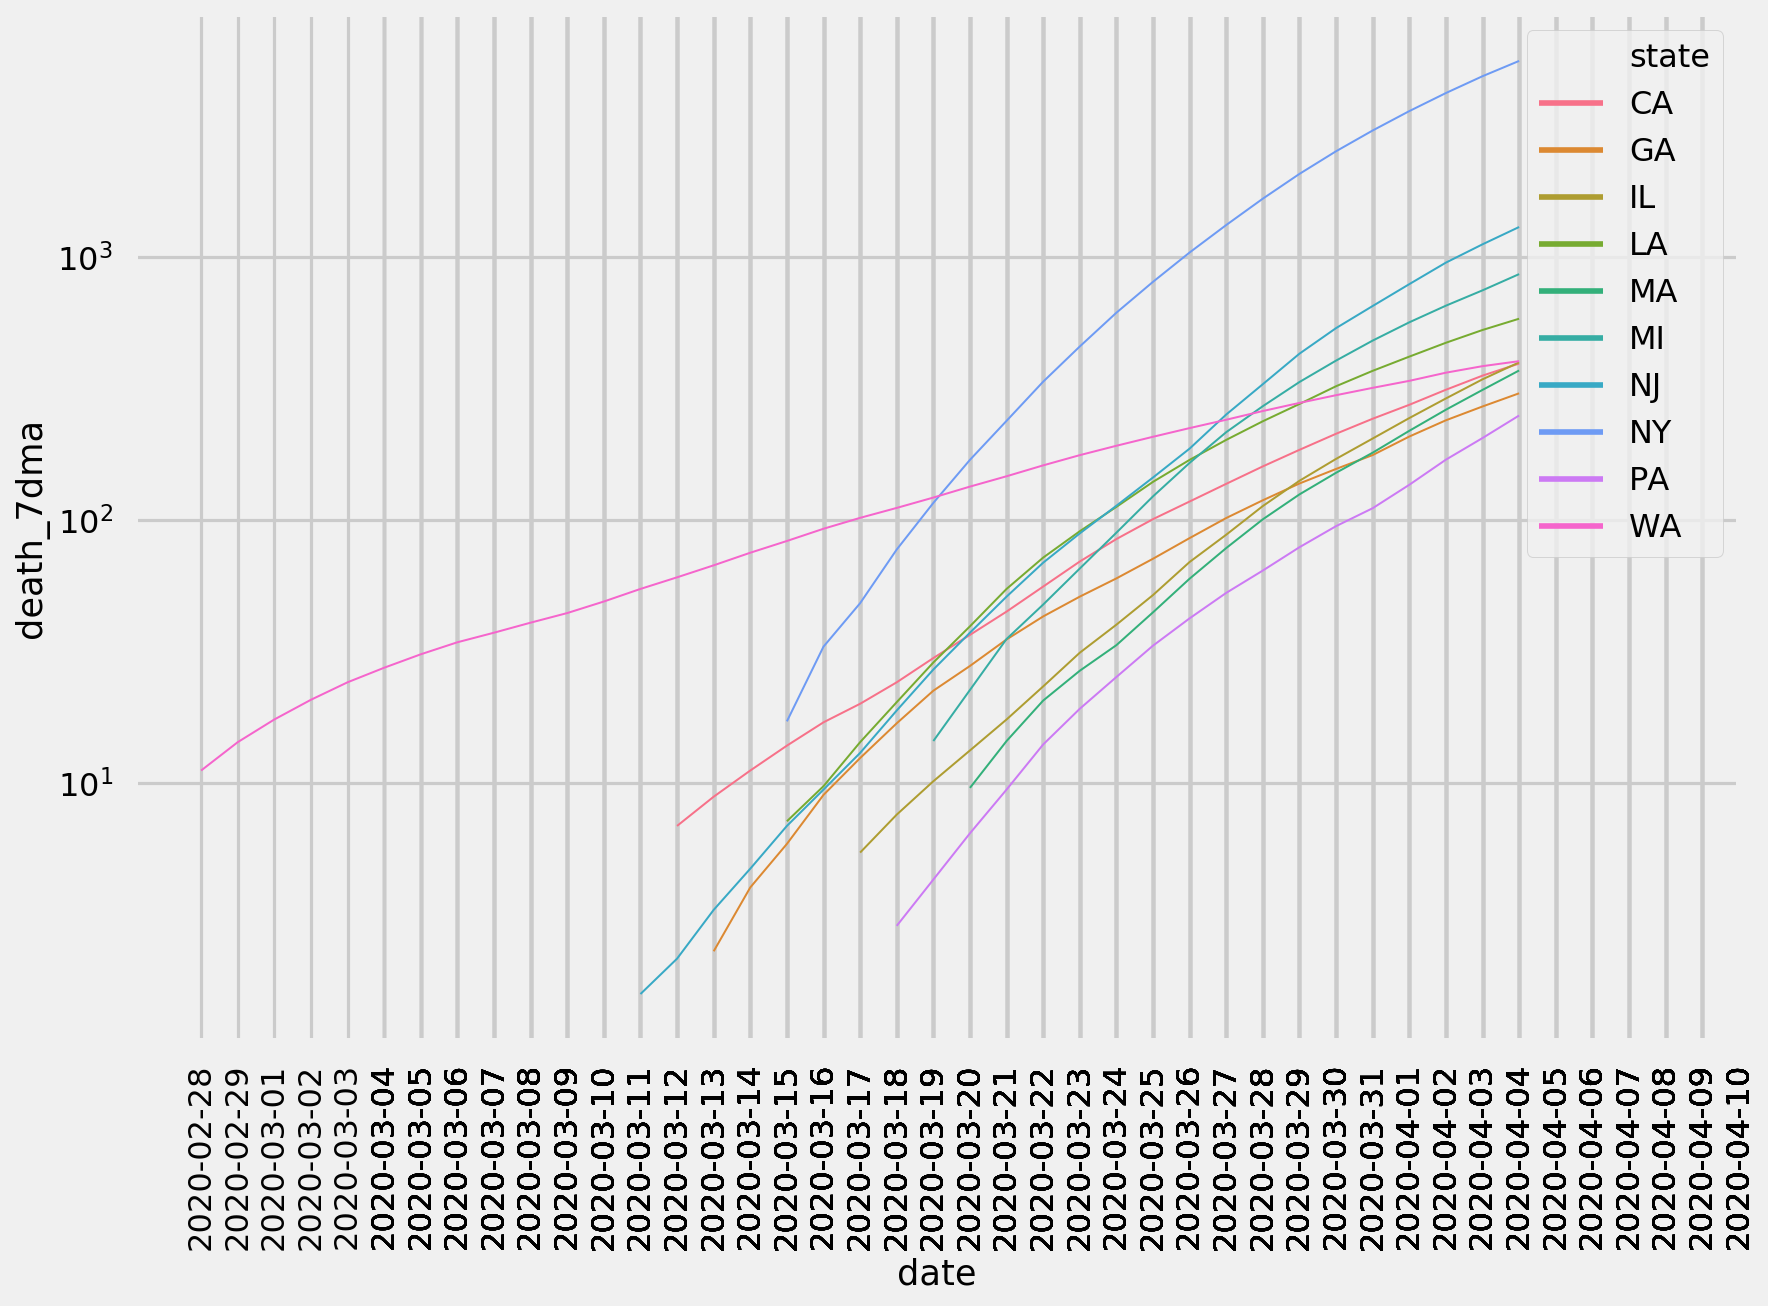

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per 100,000 People

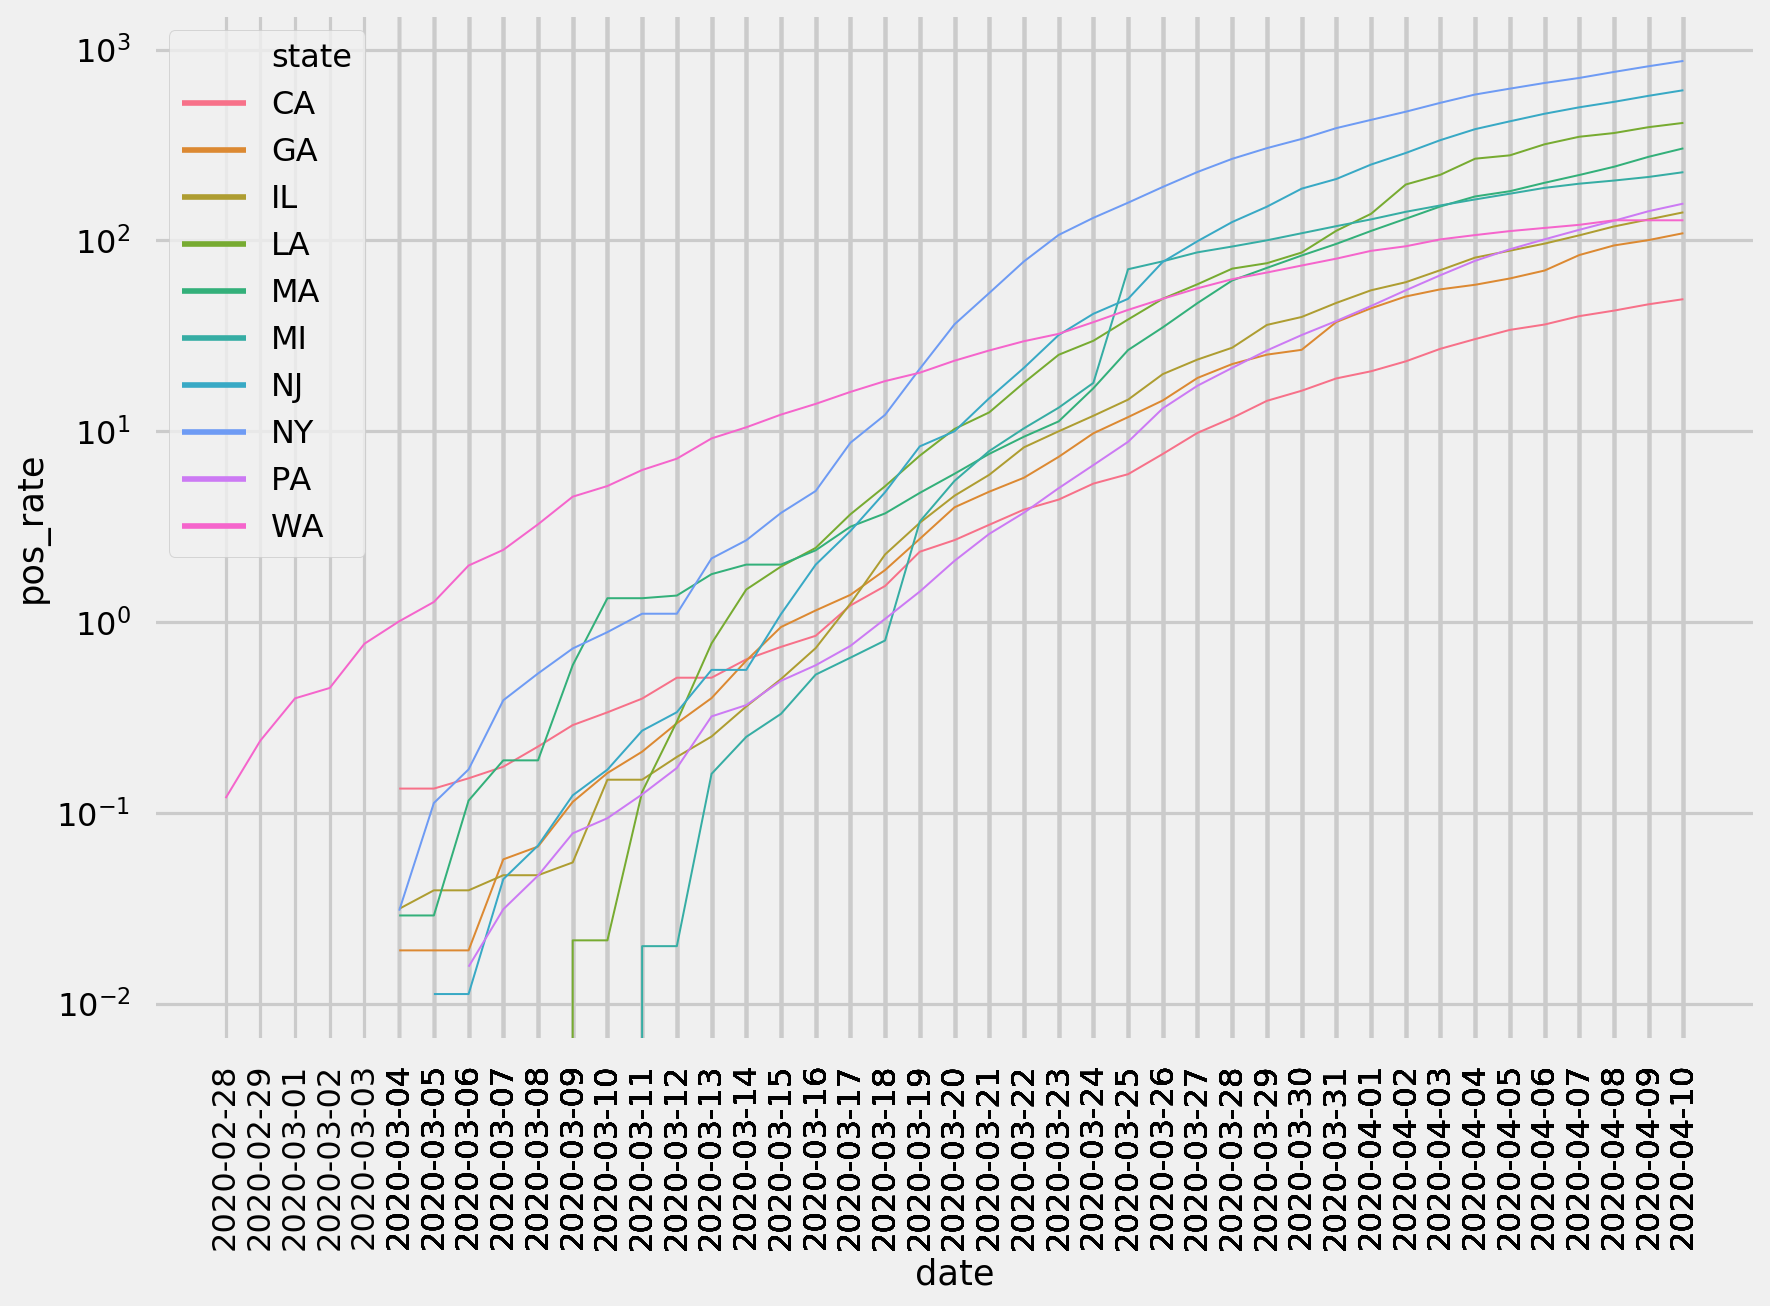

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per 100,000 People

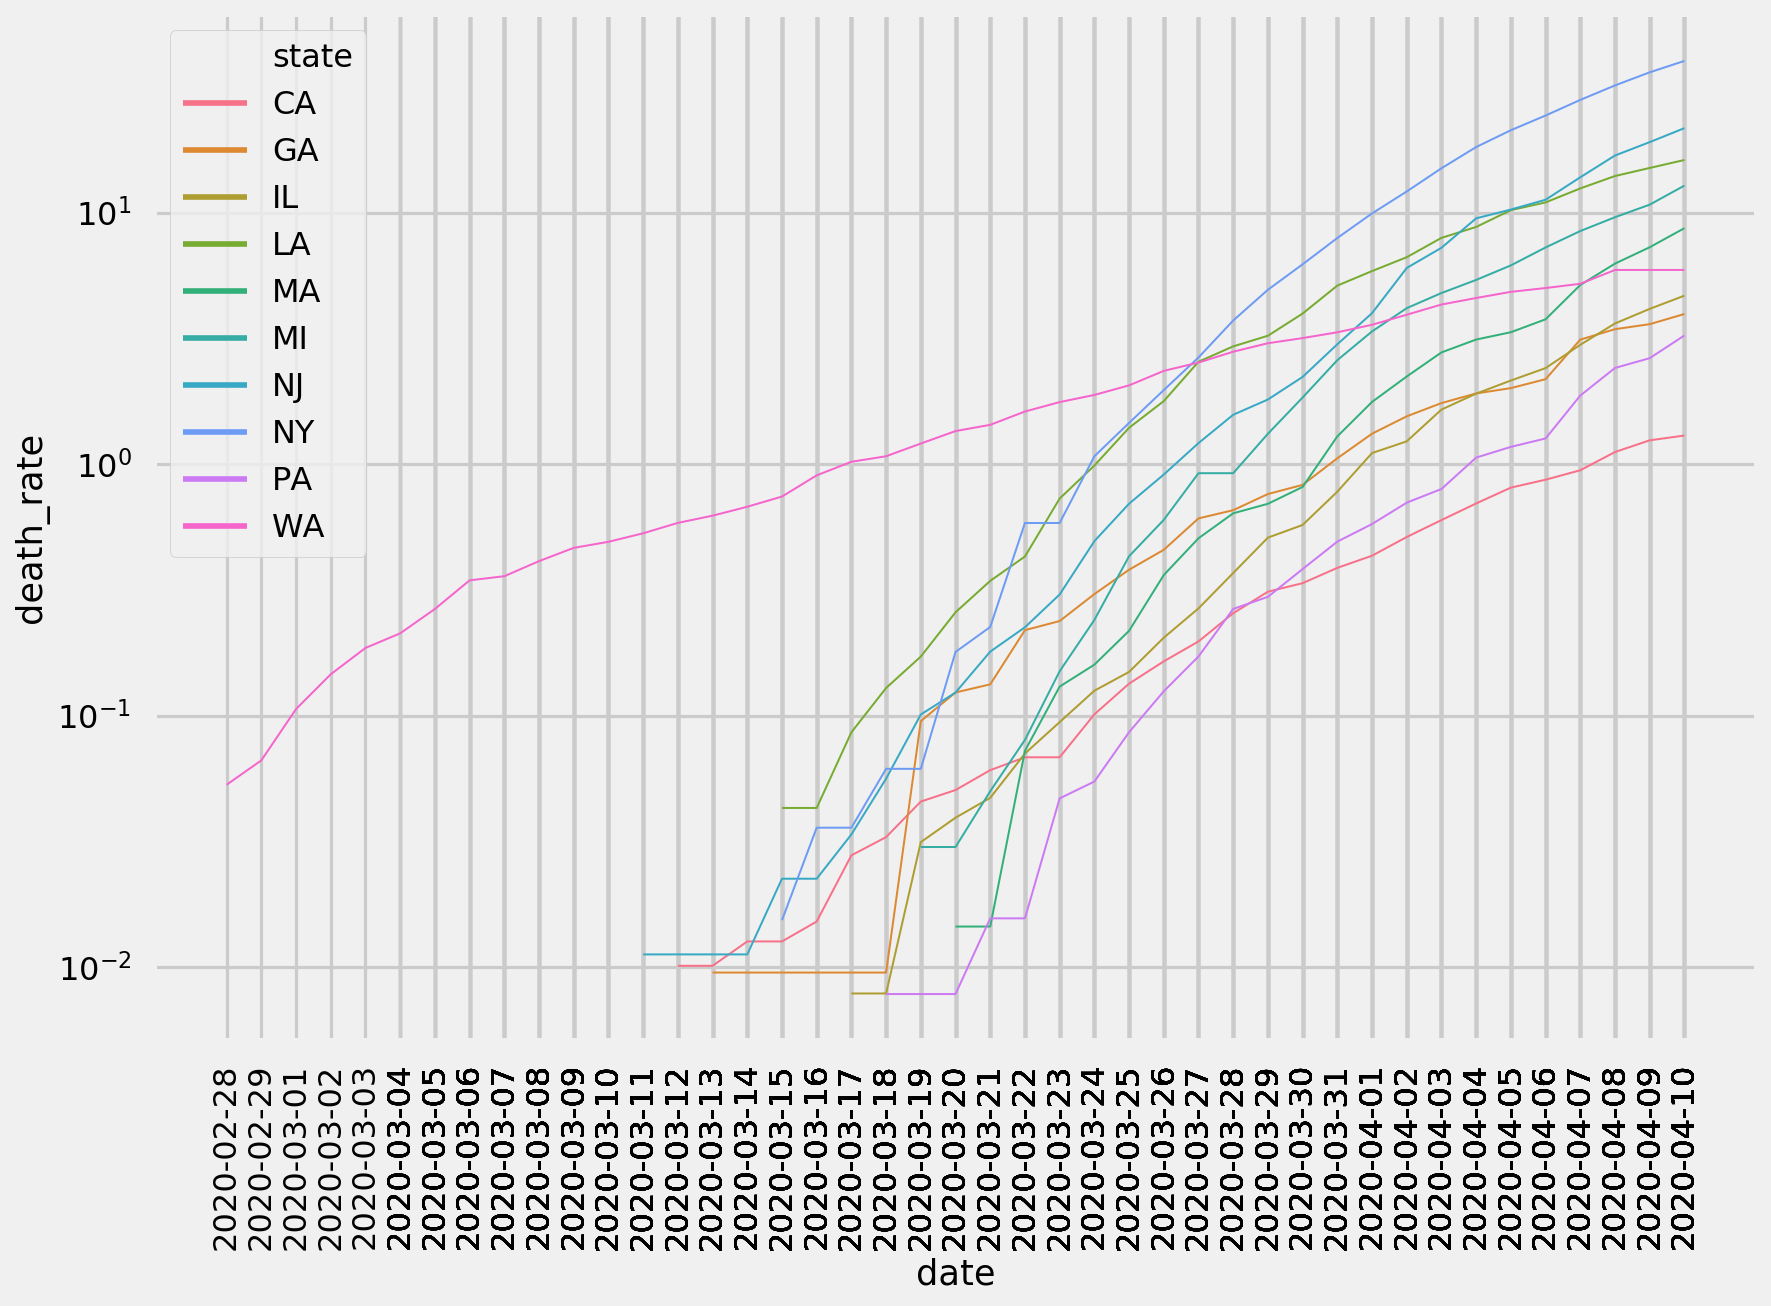

In [22]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per 100,000 People

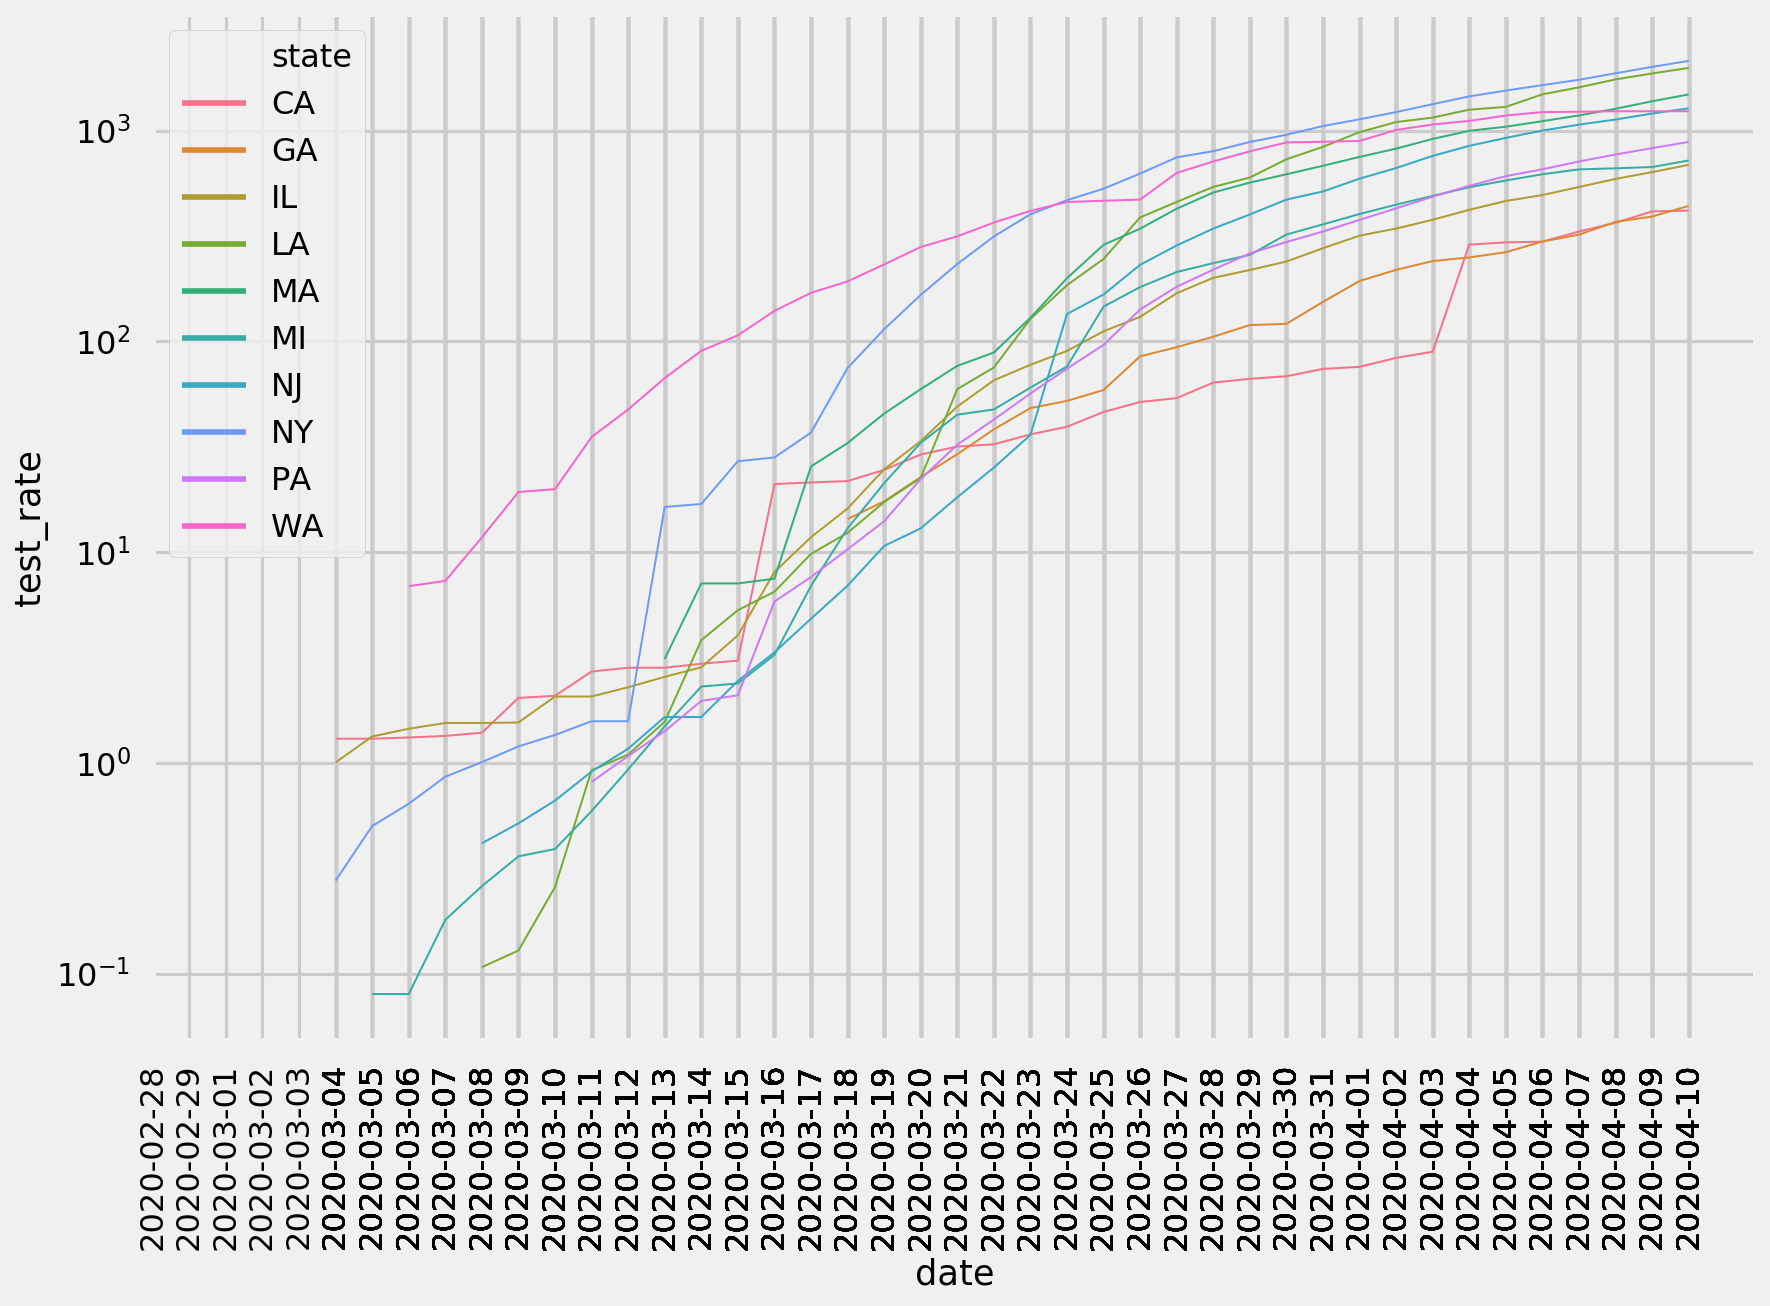

In [23]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [24]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
1237,NY,2138.371358
656,LA,1980.266860
691,MA,1483.190235
1447,RI,1352.104151
255,DC,1331.757906
1708,VT,1314.388176
1636,UT,1289.485797
1127,NJ,1274.319416
1017,ND,1264.082455
1744,WA,1234.130143
